In [1]:
import scanpy as sc
from scipy.spatial import cKDTree
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import os
import re
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from typing import Dict
import scanpy as sc
import os
import re

In [2]:

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
# your_project/analysis/spatial_analysis.py

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from sklearn.utils import check_random_state
from scipy.sparse import csr_matrix
from libpysal.weights import WSP
from esda.moran import Moran
from typing import List, Dict
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.spatial.distance import pdist, squareform
from anndata import AnnData
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import concurrent.futures
import warnings
import logging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def concatenate_and_intersect(
    adata_list: list[ad.AnnData], 
    key: str = None
) -> ad.AnnData:
    """
    Concatenates a list of AnnData objects, keeping only the intersection of their variables.

    Args:
        adata_list: List of AnnData objects to concatenate.
        key: Optional key under which the batch information is stored in `obs`.

    Returns:
        Concatenated AnnData object with intersected variables.
    """
    if not adata_list:
        raise ValueError("The list of AnnData objects is empty.")
    
    common_vars = adata_list[0].var_names
    for adata in adata_list[1:]:
        common_vars = np.intersect1d(common_vars, adata.var_names)
    
    filtered_adatas = []
    for adata in adata_list:
        mask = [var_name in common_vars for var_name in adata.var_names]
        filtered_adatas.append(adata[:, mask])
    
    concatenated_adata = ad.concat(filtered_adatas, axis=0, join='outer', merge='same', label=key)
    return concatenated_adata



def hierarchical_sample(
    adata: ad.AnnData,
    groupby_cols: list[str],
    n_samples: int | float | None = None,
    fraction: float | None = None,
    random_state: int | np.random.RandomState | None = None,
) -> ad.AnnData:
    """
    Performs hierarchical random sampling of an AnnData object based on multiple categorical variables.

    Args:
        adata: The AnnData object to sample from.
        groupby_cols: A list of column names from `adata.obs` to use for hierarchical grouping.
        n_samples: The number of samples to select from each group at the final level.
                   If a float, it's interpreted as the fraction of samples to keep.
        fraction: The fraction of samples to keep from each group at the final level.
                  If provided, `n_samples` is ignored.
        random_state: Random seed for reproducibility.

    Returns:
        A new AnnData object containing the sampled cells.
    """
    import anndata as ad
    import pandas as pd
    import numpy as np
    from sklearn.utils import check_random_state

    if (n_samples is not None and fraction is not None) or (
        n_samples is None and fraction is None
    ):
        raise ValueError("Must specify exactly one of 'n_samples' or 'fraction'.")

    rng = check_random_state(random_state)

    def _sample_group(group: pd.DataFrame, level: int) -> pd.DataFrame:
        """Recursively samples from each group."""
        if level == len(groupby_cols) - 1:
            # Sample at the final level
            if fraction is not None:
                return group.sample(frac=fraction, random_state=rng)
            elif isinstance(n_samples, int):
                return group.groupby(groupby_cols[level], group_keys=False, observed=False).apply(
                    lambda x: x.sample(n=min(n_samples, len(x)), random_state=rng)
                )
            elif isinstance(n_samples, float):
                return group.sample(frac=n_samples, random_state=rng)
        else:
            # Group by the next level and sample recursively
            return group.groupby(groupby_cols[level + 1], group_keys=False, observed=False).apply(
                lambda x: _sample_group(x, level + 1)
            )

    # Starting the hierarchical sampling from the top level
    sampled_obs = _sample_group(adata.obs, level=0)
    sampled_obs_index = sampled_obs.index.get_level_values(-1) if isinstance(sampled_obs.index, pd.MultiIndex) else sampled_obs.index

    return adata[sampled_obs_index, :].copy()


def subset_anndata(
    adata: 'anndata.AnnData', 
    conditions: dict
) -> 'anndata.AnnData':
    """
    Subsets the AnnData object to only include cells where the `.obs` column values match specified conditions.

    Args:
        adata: The AnnData object to subset.
        conditions: A dictionary where keys are column names from `adata.obs` and values are the values to match in those columns.

    Returns:
        A new AnnData object containing only the cells that match all specified conditions.
    """
    import anndata as ad
    import pandas as pd
    
    # Start with a boolean mask that includes all cells
    mask = pd.Series([True] * adata.shape[0], index=adata.obs.index)
    
    # Apply each condition to the mask
    for column, value in conditions.items():
        mask &= adata.obs[column] == value
    
    # Subset the AnnData object using the mask
    return adata[mask, :].copy()


def compute_distance_matrix(embedding: np.ndarray) -> np.ndarray:
    """
    Computes the pairwise distance matrix for a given embedding.

    Args:
        embedding: A 2D numpy array where rows represent points and columns represent dimensions.

    Returns:
        A 2D numpy array representing the pairwise distance matrix.
    """
    return squareform(pdist(embedding, 'euclidean'))

def compute_weight_matrix_from_distances(distance_matrix: np.ndarray) -> np.ndarray:
    """
    Computes the weight matrix from a distance matrix using inverse distances.

    Args:
        distance_matrix: A 2D numpy array representing the pairwise distance matrix.

    Returns:
        A 2D numpy array representing the weight matrix.
    """
    with np.errstate(divide='ignore'):
        weight_matrix = 1 / distance_matrix
    np.fill_diagonal(weight_matrix, 0)  # weights for self-distance are set to zero
    return weight_matrix

def scale_values(values: np.ndarray, scaling_method: str, apply_log: bool, log_before_scaling: bool) -> np.ndarray:
    """
    Scales and optionally log-transforms the values.

    Args:
        values: The values to scale.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        The scaled (and optionally log-transformed) values.
    """
    if apply_log and log_before_scaling:
        values = np.log1p(values)

    if scaling_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    if scaler is not None:
        values = scaler.fit_transform(values.reshape(-1, 1)).flatten()

    if apply_log and not log_before_scaling:
        values = np.log1p(values)

    return values

def neighbor_compute_moran_i(sub_adata: AnnData, value_key: str, category: str, use_embedding: bool = False, embedding_key: str = None, scaling_method: str = None, apply_log: bool = False, log_before_scaling: bool = False) -> dict:
    """
    Computes Moran's I spatial autocorrelation for a subset of cells.

    Args:
        sub_adata: Subset of AnnData object for specific cell type.
        value_key: The key in `sub_adata.obs` containing the values to analyze.
        category: The categorical variable in `sub_adata.obs` to group by.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `sub_adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        A dictionary with Moran's I results.
    """
    try:
        if use_embedding and embedding_key is not None:
            embedding = sub_adata.obsm[embedding_key]
            distance_matrix = compute_distance_matrix(embedding)
            weight_matrix = compute_weight_matrix_from_distances(distance_matrix)
            sparse_weight_matrix = csr_matrix(weight_matrix)
            weights = WSP(sparse_weight_matrix)
        else:
            connectivities = sub_adata.obsp['connectivities']
            weights = WSP(connectivities)
    except KeyError as e:
        raise KeyError(f"Key error: {e}")

    values = sub_adata.obs[value_key].values
    values = scale_values(values, scaling_method, apply_log, log_before_scaling)
    weights_full = weights.to_W()
    moran = Moran(values, weights_full)
    return {
        category: sub_adata.obs[category].unique()[0],
        "Moran's I": moran.I,
        "P-value": moran.p_norm,
        "num_cell": len(values)
    }

def neighbor_process_cell_type(adata: AnnData, cell_type: str, value_key: str, category: str, use_embedding: bool = False, embedding_key: str = None, scaling_method: str = None, apply_log: bool = False, log_before_scaling: bool = False) -> pd.DataFrame:
    """
    Processes a specific cell type to compute Moran's I.

    Args:
        adata: The AnnData object to analyze.
        cell_type: The specific cell type to process.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        A DataFrame with Moran's I results for the specific cell type.
    """
    mask = adata.obs[category] == cell_type
    num_cell = sum(mask)
    if num_cell > 10:
        sub_adata = adata[mask].copy()
        moranI_data = neighbor_compute_moran_i(sub_adata, value_key, category, use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling)
        return pd.DataFrame([moranI_data])
    return pd.DataFrame()





def process_cell_type(cell_type, adata, value_key, category, use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling):
    """
    Processes a specific cell type to compute Moran's I.

    Args:
        adata: The AnnData object to analyze.
        cell_type: The specific cell type to process.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        A DataFrame with Moran's I results for the specific cell type.
    """
    logging.info(f"Processing cell type: {cell_type}")
    mask = adata.obs[category] == cell_type
    num_cell = sum(mask)
    if num_cell > 10:
        sub_adata = adata[mask].copy()
        moranI_data = neighbor_compute_moran_i(sub_adata, value_key, category, use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling)
        return pd.DataFrame([moranI_data])
    else:
        logging.warning(f"No data available for cell type: {cell_type} (insufficient number of cells or other issues).")
        return pd.DataFrame()

def compute_neighbor_moran_i_by_category(
    adata: AnnData, 
    value_key: str, 
    category: str = "celltype", 
    connectivity_key: str = 'connectivities',
    use_embedding: bool = False,
    embedding_key: str = None,
    scaling_method: str = None,
    apply_log: bool = False,
    log_before_scaling: bool = False,
    max_workers: int = None,
    specific_celltype: list = None  # New argument to specify a single cell type
) -> pd.DataFrame:
    """
    Computes Moran's I spatial autocorrelation for each cell type, or a specific cell type, in parallel.

    Args:
        adata: The AnnData object to analyze.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        connectivity_key: The key in `adata.obsp` containing the connectivities matrix.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.
        max_workers: The maximum number of threads to use for parallel processing.
        specific_celltype: A specific cell type to analyze. If provided, only this cell type will be analyzed.

    Returns:
        A DataFrame with Moran's I results for each cell type, or the specific cell type.
    """
    logging.info(f"Starting Moran's I computation with value key '{value_key}'.")

    # Determine the cell types to analyze
    if specific_celltype:
        logging.info(f"Analyzing specific cell type: {specific_celltype}")
        top_level_types = specific_celltype
    else:
        top_level_types = adata.obs[category].unique()
        logging.info(f"Identified {len(top_level_types)} unique cell types in category '{category}'.")

    result_df = pd.DataFrame()

    # Define a function to process each cell type, to be used with the thread pool
    def process_cell_type(cell_type):
        logging.info(f"Processing cell type: {cell_type}")
        cell_type_df = neighbor_process_cell_type(
            adata, cell_type, value_key, category, 
            use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling
        )
        if cell_type_df.empty:
            logging.warning(f"No data available for cell type: {cell_type} (insufficient number of cells or other issues).")
        return cell_type_df

    # Use ThreadPoolExecutor to parallelize the execution if analyzing multiple cell types
    if len(top_level_types) > 1:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(process_cell_type, top_level_types))
    else:
        # If only one cell type is being analyzed, process it directly without parallelization
        results = [process_cell_type(top_level_types[0])]

    # Concatenate all results
    for cell_type_df in results:
        if not cell_type_df.empty:
            result_df = pd.concat([result_df, cell_type_df])

    if result_df.empty:
        logging.warning("No data was processed successfully. Returning an empty DataFrame.")
        return pd.DataFrame()

    result_df = result_df.set_index(category)
    result_df = result_df.sort_values("Moran's I", ascending=False)
    logging.info("Completed Moran's I computation.")

    return result_df





def identify_nearby_cells(
    merge_adata: ad.AnnData,
    label_column: str = 'celltype',
    target_col: str = 'datatype',
    targed_label: str = 'sn',
    threshold: float = 0.1,
    new_label_col: str = 'nearby_label'
) -> ad.AnnData:
    """
    Identifies and labels nearby cells in an AnnData object based on a threshold in the neighbor graph.

    Args:
        merge_adata: The AnnData object containing cells with connectivity information.
        label_column: The column name in `merge_adata.obs` which contains the labels for the target cells.
        target_col: The column name in `merge_adata.obs` representing labeled and unlabeled cells.
        targed_label: The label in `target_col` to consider as the source of nearby cells.
        threshold: The threshold for considering a cell "near" based on the neighbor graph connectivity.
        new_label_col: The column name to store new labels for nearby cells.

    Returns:
        A new AnnData object containing only the nearby cells that were identified.
    """
    import anndata as ad
    import numpy as np

    celltypes = merge_adata.obs[label_column].unique()
    merge_adata.obs[new_label_col] = 'unlabeled'  # Default value for cells that are not nearby
    nearby_cellbin_indices_dict = {}

    for celltype in celltypes:
        print(f"Processing celltype: {celltype}")
        sn_mask = (merge_adata.obs[target_col] == targed_label) & (merge_adata.obs[label_column] == celltype)
        cellbin_mask = (merge_adata.obs[target_col] != targed_label) & (merge_adata.obs[label_column] == celltype)
        neighbor_graph = merge_adata.obsp['connectivities']
        sn_indices = np.where(sn_mask)[0]
        cellbin_indices = np.where(cellbin_mask)[0]

        if len(sn_indices) == 0 or len(cellbin_indices) == 0:
            print(f"No labeled or unlabeled cells found for celltype: {celltype}")
            continue

        neighbor_sums = neighbor_graph[sn_indices].sum(axis=0)
        neighbor_sums = np.asarray(neighbor_sums).flatten()
        nearby_cellbin_indices = cellbin_indices[neighbor_sums[cellbin_indices] > threshold]

        if len(nearby_cellbin_indices) > 0:
            nearby_cellbin_indices_dict[celltype] = nearby_cellbin_indices
            merge_adata.obs.loc[merge_adata.obs.index[nearby_cellbin_indices], new_label_col] = f'near_{celltype}'
        else:
            print(f"No nearby unlabeled cells found for celltype: {celltype}")

    all_nearby_cellbin_indices = np.concatenate(list(nearby_cellbin_indices_dict.values()))
    print(f"Total nearby unlabeled cells found: {merge_adata[all_nearby_cellbin_indices].shape[0]}")

    return merge_adata[all_nearby_cellbin_indices].copy()


In [4]:
import pandas as pd
import concurrent.futures

def read_csv_files_concurrently(file_dict):
    """
    Reads multiple CSV files concurrently and returns a dictionary of DataFrames.

    :param file_dict: Dictionary where the key is a variable name and the value is the path to the CSV file.
    :return: Dictionary where the key is the variable name and the value is the corresponding DataFrame.
    """
    def load_csv(key, path):
        print(f"Reading {key}")
        return key, pd.read_csv(path)

    result_dict = {}
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_key = {executor.submit(load_csv, key, path): key for key, path in file_dict.items()}
        
        for future in concurrent.futures.as_completed(future_to_key):
            key, df = future.result()
            result_dict[key] = df
            
    return result_dict


In [5]:
def list_files_matching_criteria(directory: str, condition: str = None, regex: str = None, separator: str = "_", id_index: int = 0) -> dict:
    """
    Lists files in a directory matching a given condition or regular expression and extracts an ID from the filename.

    Args:
        directory: The directory to search for files.
        condition: The conditional equation to filter files by. The condition should be a valid Python expression
                   where 'file' can be used as the variable.
        regex: The regular expression to filter files by.
        separator: The separator used to split the filenames.
        id_index: The index of the split result to be used as the dictionary key.

    Returns:
        A dictionary where the keys are the specified parts of the filenames (split by the separator)
        and the values are the full file paths of the files that match the condition or regex.
    """
    files = sorted(os.listdir(directory))

    # Filter files based on condition or regex
    if condition:
        filtered_files = [file for file in files if eval(condition)]
    elif regex:
        pattern = re.compile(regex)
        filtered_files = [file for file in files if pattern.search(file)]
    else:
        filtered_files = files


    # Create the dictionary with the specified part of the filenames as keys
    paths = {file.split(separator)[id_index]: os.path.join(directory, file) for file in filtered_files}
    
    return paths


def load_data_in_parallel(file_paths: dict, load_function: callable) -> dict:
    """
    Loads data from multiple files in parallel using a specified load function.

    Args:
        file_paths: A dictionary where the keys are identifiers and the values are file paths.
        load_function: The function to use for loading data from each file path.

    Returns:
        A dictionary where the keys are identifiers and the values are the loaded data.
    """
    data = {}
    with ProcessPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(load_function, path): file for file, path in file_paths.items()}
        for future in futures:
            key = futures[future]
            try:
                data[key] = future.result()
            except Exception as exc:
                print(f"Error loading file {key}: {exc}")
    return data

In [6]:
hz_files = list_files_matching_criteria("/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/regress_harmony/", "'coorect' in file and 'h5ad' in file", separator=".")
all_files = {}
for key, path in hz_files.items():
    all_files[key.split("_")[0] + "_" + key.split("_")[2]] = path

In [7]:
adatas = load_data_in_parallel(all_files, sc.read_h5ad)

In [8]:
bf_datas = {}
for key, adata in adatas.items():
    if "BF" in key:
        bf_datas[key] = adata

In [25]:
print(adata.raw[:,"Chat"].X)

  (7573, 0)	2.7269186854065928
  (11233, 0)	2.887542901695687
  (11239, 0)	2.463098791016768
  (11242, 0)	2.6763393329100147
  (11303, 0)	2.752659434940183
  (11312, 0)	3.7534179752515073
  (11938, 0)	2.541279613375632
  (12279, 0)	2.4572235330968035
  (14245, 0)	3.5344999627535785


In [29]:
for key, adata in bf_datas.items():
    try:
        print(key)
        mask = adata.raw[:, "Chat"].X.toarray().flatten() > 0
        bf_datas[key].obs["new_fine"] = bf_datas[key].obs["fine"]
        bf_datas[key].obs["new_fine"] = bf_datas[key].obs["new_fine"].astype(str)
        bf_datas[key].obs.loc[mask, "new_fine"] = "ChN"
    except Exception as exc:
        print(f"{key}: {exc}")

HZ12M01_BF
HZ12M02_BF
HZ12M03_BF
HZ12M04_BF
HZ12M05_BF
HZ12M06_BF
HZ2M01_BF
HZ2M02_BF
HZ2M03_BF
HZ2M04_BF
HZ2M05_BF
HZ2M06_BF
HZ3M01_BF
HZ3M02_BF
HZ3M03_BF
HZ3M04_BF
HZ3M05_BF
HZ3M06_BF
HZ4M03_BF
HZ4M05_BF
HZ4MP101_BF
HZ4MP102_BF
HZ4MP202_BF
HZ5M01_BF
HZ5M02_BF
HZ5M03_BF
HZ5M04_BF
HZ5M05_BF
HZ5M06_BF
HZ6M02_BF
HZ6M03_BF
HZ6M04_BF
HZ6M05_BF
HZ6M06_BF
HZ6MP101_BF
HZ6MP102_BF
HZ6MP202_BF
HZ8M01_BF
HZ8M02_BF
HZ8M03_BF
HZ8M04_BF
HZ8M05_BF
HZ8M06_BF


In [33]:
bf_datas

{'HZ12M01_BF': AnnData object with n_obs × n_vars = 13254 × 4079
     obs: 'Unnamed: 0.1', 'Unnamed: 0', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'fine', 'genotype', 'month', 'sample', 'slice', 'id_A', 'age', 'nearest_plaque', 'interval', 'min_center_dist', 'min_border_dist', 'plaque_region', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'nearest_index', 'struct_id', 'acronym_x', 'id_B', 'atlas_id', 'name', 'acronym_y', 'st_level', 'ontology_id', 'hemisphere_id', 'weight', 'parent_structure_id', 'depth', 'graph_id', 'graph_order', 'structure_id_path', 'color_hex_triplet', 'neuro_name_structure_id', 'neuro_name_structure_id_path', 'failed', 'sphinx_id', 'structure_name_facet', 'failed_facet', 'safe_name', 'total_voxel_counts (10 um)', 'Structure independently delineated (not merged to form parents)', 'Major Division', '"Summary Structure" Level for Analyses', 'Structure Name', 'datatype', 'region_abb', 'nCount_RNA', 'nFeature_RNA', 'batch', 'plaque', 'pl

In [86]:
bf_all_dfs = {}

# Define a function to process each adata
def process_data(key, adata):
    print(key)
    df = compute_neighbor_moran_i_by_category(
        adata, 
        value_key="min_center_dist", 
        category="fine", 
        use_embedding=True, 
        embedding_key="X_pca_harmony", 
        sp
    )
    return key, df
    
# Use ThreadPoolExecutor to run the processing in parallel
with ThreadPoolExecutor(max_workers=8) as executor:
    # Create a list of futures
    futures = {executor.submit(process_data, key, adata): key for key, adata in bf_datas.items()}
    
    # Collect the results as they complete
    for future in futures:
        key, df = future.result()
        bf_all_dfs[key] = df

2024-08-28 09:05:08,942 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
2024-08-28 09:05:09,705 - INFO - Starting Moran's I computation with value key 'min_center_dist'.


HZ12M01_BF
HZ12M02_BF
HZ12M03_BF
HZ12M04_BF
HZ12M05_BF
HZ12M06_BF
HZ2M01_BF
HZ2M02_BF


2024-08-28 09:05:09,857 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
2024-08-28 09:05:09,897 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
IOStream.flush timed out
2024-08-28 09:05:09,939 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
2024-08-28 09:05:10,030 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
IOStream.flush timed out
2024-08-28 09:05:10,202 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
2024-08-28 09:05:10,298 - INFO - Identified 40 unique cell types in category 'fine'.
2024-08-28 09:05:10,349 - INFO - Starting Moran's I computation with value key 'min_center_dist'.
2024-08-28 09:05:14,160 - INFO - Identified 44 unique cell types in category 'fine'.
2024-08-28 09:05:41,934 - INFO - Identified 44 unique cell types in category 'fine'.
2024-08-28 09:05:45,957 - INFO - Identified 45 unique cell types in category 'fine'.
2024-08-28 09:06:00,90

In [49]:
bf_dfs

{'HZ12M01_BF':           Moran's I  P-value  num_cell
 celltype                              
 ExN        0.006817      0.0      1366,
 'HZ12M02_BF':           Moran's I  P-value  num_cell
 celltype                              
 ExN        0.007717      0.0      2709,
 'HZ12M03_BF':           Moran's I  P-value  num_cell
 celltype                              
 ExN        0.002688      0.0      2716,
 'HZ12M04_BF':           Moran's I  P-value  num_cell
 celltype                              
 ExN        0.005317      0.0      2433,
 'HZ12M05_BF':           Moran's I  P-value  num_cell
 celltype                              
 ExN        0.006542      0.0      2279,
 'HZ12M06_BF':           Moran's I  P-value  num_cell
 celltype                              
 ExN        0.005187      0.0      2524,
 'HZ2M01_BF':           Moran's I        P-value  num_cell
 celltype                                    
 ExN        0.001703  2.700871e-117      2384,
 'HZ2M02_BF':           Moran's I  P-v

In [50]:
for key, df in bf_dfs.items():
    df["id"] = key

In [51]:
merged_exn = pd.concat(bf_dfs.values())

In [52]:
filtered_exn = merged_exn[merged_exn["P-value"] < 0.05]

In [77]:
filtered_exn["month"] = filtered_exn["id"].str.split("M").str[0].str.split("Z").str[1]

/tmp/ipykernel_283685/3600972282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exn["month"] = filtered_exn["id"].str.split("M").str[0].str.split("Z").str[1]


/tmp/ipykernel_283685/2786766153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exn["month"] = filtered_exn["month"].astype(str)


In [78]:
from pandas.api.types import CategoricalDtype
categories = ['2', '3', '4', '5',  '6', '8', '12']
cat_type = CategoricalDtype(categories=categories, ordered=True)

In [79]:
filtered_exn["month"] = filtered_exn["month"].astype(cat_type)

/tmp/ipykernel_283685/2361273785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_exn["month"] = filtered_exn["month"].astype(cat_type)


In [80]:
filtered_exn["month"]

celltype
ExN    12
ExN    12
ExN    12
ExN    12
ExN    12
ExN    12
ExN     2
ExN     2
ExN     2
ExN     2
ExN     2
ExN     2
ExN     3
ExN     3
ExN     3
ExN     3
ExN     3
ExN     3
ExN     4
ExN     4
ExN     4
ExN     4
ExN     5
ExN     5
ExN     5
ExN     5
ExN     5
ExN     5
ExN     6
ExN     6
ExN     6
ExN     6
ExN     6
ExN     6
ExN     6
ExN     6
ExN     8
ExN     8
ExN     8
ExN     8
ExN     8
ExN     8
Name: month, dtype: category
Categories (7, object): ['2' < '3' < '4' < '5' < '6' < '8' < '12']

2024-08-28 08:56:26,961 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-28 08:56:26,985 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


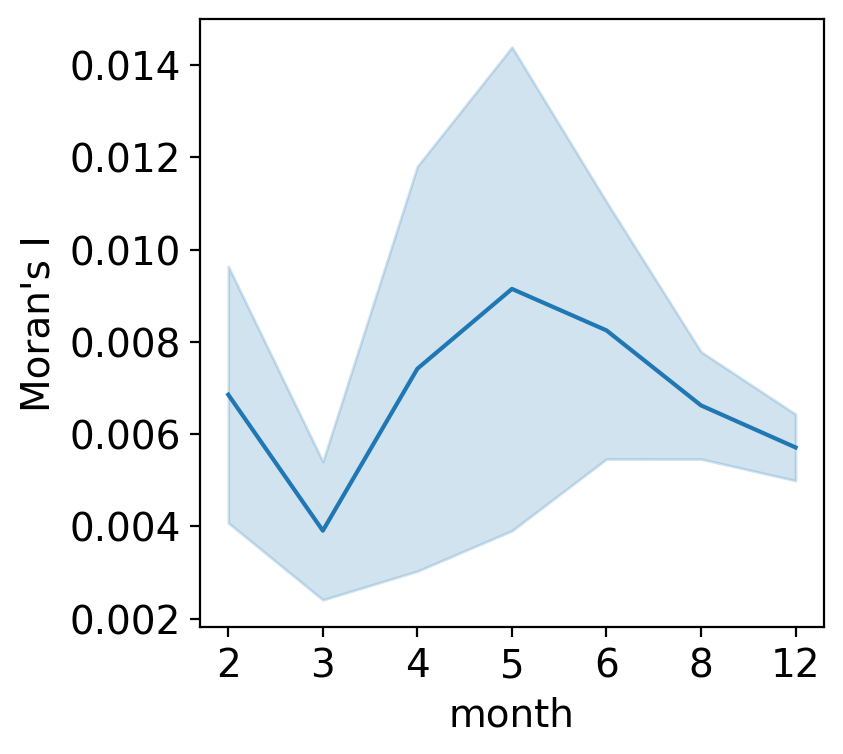

In [84]:
ax = sns.lineplot(data = filtered_exn, x = "month", y = "Moran's I", errorbar="se")
ax.grid(False)
plt.show()

In [44]:
merged_chn = pd.concat(bf_dfs.values())

In [45]:
filtered_chn = merged_chn[merged_chn["P-value"] < 0.05]

In [46]:
filtered_chn["month"] = filtered_chn

,Moran's I,P-value,num_cell,id
ChN,-0.007082,3.204002e-02,86.0,HZ12M01_BF
ChN,-0.005345,1.517024e-02,102.0,HZ3M05_BF
ChN,-0.004432,1.007515e-04,72.0,HZ4MP101_BF
ChN,-0.014411,6.766335e-05,27.0,HZ4MP202_BF
ChN,-0.003657,2.659447e-03,126.0,HZ5M03_BF
ChN,-0.001736,1.634473e-04,138.0,HZ6M03_BF
ChN,0.000505,8.573792e-07,224.0,HZ6MP101_BF
ChN,0.000715,3.485853e-07,31.0,HZ6MP202_BF
ChN,-0.004306,1.306294e-03,101.0,HZ8M01_BF


# 其他

In [7]:
import scanpy as sc
from concurrent.futures import ThreadPoolExecutor, as_completed

# Assuming all_files is a dictionary where keys are filenames and values are file paths.
adatas = {}

# Define the function to read files
def load_file(key, path):
    print(key)
    return key, sc.read_h5ad(path)

# Use ThreadPoolExecutor for parallel execution
with ThreadPoolExecutor() as executor:
    # Submit tasks to the executor
    futures = {executor.submit(load_file, key, path): key for key, path in all_files.items()}
    
    # Collect the results as they complete
    for future in as_completed(futures):
        key, data = future.result()
        adatas[key] = data



In [7]:
adata = sc.read_h5ad(hz_files["HZ12M01"])

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata

AnnData object with n_obs × n_vars = 119471 × 3000
    obs: 'Unnamed: 0.1', 'Unnamed: 0', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'fine', 'index', 'nCount_SCT', 'nFeature_SCT', 'safe_name', 'structure_id_path', 'color_hex_triplet', 'sample', 'min_center_dist'
    var: 'features'

In [8]:
adata = adata.raw.to_adata()

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Find variable features
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
adata = adata[:, adata.var.highly_variable].copy()
# Scale the data
sc.pp.scale(adata)
# Run PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:02:01)


In [12]:
df = compute_neighbor_moran_i_by_category(adata, value_key = "min_center_dist", category = "fine", use_embedding=True,
                                                             embedding_key="X_pca", scaling_method="minmax")


2024-08-26 09:55:06,442 - INFO - Starting Moran's I computation for each cell type in category 'fine' with value key 'min_center_dist'.
2024-08-26 09:55:06,446 - INFO - Identified 45 unique cell types in category 'fine'.
2024-08-26 09:56:23,128 - INFO - Processing cell type: OPC-2
2024-08-26 09:56:50,419 - INFO - Processing cell type: ExN-DEGLU-2
2024-08-26 09:57:18,551 - INFO - Processing cell type: SMC
2024-08-26 09:57:52,616 - INFO - Processing cell type: Astro-5
2024-08-26 09:58:24,698 - INFO - Processing cell type: Astro-6
2024-08-26 09:58:52,034 - INFO - Processing cell type: Micro-1
2024-08-26 09:59:20,212 - INFO - Processing cell type: ExN-L6b
2024-08-26 09:59:47,993 - INFO - Processing cell type: Astro-2
2024-08-26 10:00:19,409 - INFO - Processing cell type: Micro-3
2024-08-26 10:00:46,284 - INFO - Processing cell type: ExN-DEGLU-1
2024-08-26 10:01:17,575 - INFO - Processing cell type: Peri
2024-08-26 10:01:37,983 - INFO - Processing cell type: Olig-3
2024-08-26 10:02:11,682 -

In [13]:
df

,Moran's I,P-value,num_cell
fine,,,
Peri,0.008614,0.000000e+00,4423
ExN-DG,0.006931,0.000000e+00,2932
OPC-2,0.006796,8.791881e-183,895
SMC,0.006534,0.000000e+00,9066
ExN-DEGLU-1,0.005425,0.000000e+00,3115
Endo,0.005414,0.000000e+00,3540
ExN-L6b,0.005363,1.637194e-199,950
Astro-4,0.004375,8.837044e-188,1367
InN-Erbb4,0.004225,0.000000e+00,2368
